In [ ]:
import torch

# Basic Tensor data type

In [ ]:
x = torch.tensor([1, 2, 3])
y = torch.rand(3, 3)

In [ ]:
print(f"x = {x}")
print(f"y = {y}")
print(f"x + y = {x + y}")

x = tensor([1, 2, 3])
y = tensor([[0.7508, 0.0624, 0.2065],
        [0.2747, 0.4145, 0.3729],
        [0.9187, 0.1907, 0.5265]])
x + y = tensor([[1.7508, 2.0624, 3.2065],
        [1.2747, 2.4145, 3.3729],
        [1.9187, 2.1907, 3.5265]])


In [ ]:
x = torch.tensor([[3,4]])
x.shape
## a matrix of 1 rows and 2 cols

torch.Size([1, 2])

# Some imp functions

1. torch.stack

In [ ]:
a = torch.tensor([1, 2])
b = torch.tensor([3, 4])

# Stack along a new dimension (dim=0)
# [a, b] = [[1,2], [3,4]] but which dim should be new axis??
c = torch.stack([a, b], dim=0)  ## dim = 0, means new axis will be rows
print(c)

tensor([[1, 2],
        [3, 4]])


In [ ]:
c = torch.stack([a, b], dim=1) ## dim = 1, means new axis will be cols
print(c)

tensor([[1, 3],
        [2, 4]])


2. torch.cat

In [ ]:
a = torch.tensor([[1, 2]])
b = torch.tensor([[3, 4]])

c = torch.cat([a, b], dim=0)  # concatenate along rows
print(c)


tensor([[1, 2],
        [3, 4]])


In [ ]:
c = torch.cat([a, b], dim=1)
print(c)

## cat merges along existing axis
## stack adds a new axis

tensor([[1, 2, 3, 4]])


3. torch.unsqueeze

In [ ]:
a = torch.tensor([1, 2])
b = torch.tensor([3, 4])

print(f"a.shape = {a.shape}")
# Unsqueeze to add a new dimension
a2 = a.unsqueeze(0)  # shape [1, 2]
b2 = b.unsqueeze(0)  # shape [1, 2]

print(f"a2 = {a2}")
print(f"a2.shape = {a2.shape}")

c = torch.cat([a2, b2], dim=0)
print(c)

# Looks similar to stack, but here we manually added a dimension before concatenating.

a.shape = torch.Size([2])
a2 = tensor([[1, 2]])
a2.shape = torch.Size([1, 2])
tensor([[1, 2],
        [3, 4]])


# Gradient Computation

In [ ]:
x = torch.tensor([2.0], requires_grad=True)  ## for gradient, tensor must be float / complex
y = x ** 2

In [ ]:
print(f"x = {x}")
print(f"y = {y}")

x = tensor([2.], requires_grad=True)
y = tensor([4.], grad_fn=<PowBackward0>)


In [ ]:
y.backward()  ## computes grad, more detail to follow

In [ ]:
print(x.grad)  ## this means that dy/dx at x=2; is 4

tensor([4.])


In [ ]:
## Now suppose we want to check grad at many points
x = torch.tensor([2.0, 4.0, 6.0], requires_grad=True)
y = x ** 2

- Inputs: $x_{0} , x_{1}$
    
- Outputs: $y_{0} = x_{0}^{2} , y_{1} = x_{1}^{2}$​
    
- Total “loss” if you sum:
    

$$L = y_{0} + y_{1} = x_{0}^{2} + x_{1}^{2}$$

- Then the **gradients w.r.t each input** are:
    

$$\frac{\partial L}{\partial x_{0}} = 2 x_{0} , \frac{\partial L}{\partial x_{1}} = 2 x_{1}$$

In [ ]:
## if you simple do y.backward() it fails
## at this point, for each x; y = [4.0, 16.0, 36.0]
## but we want der on each single point, not for a vector, so we sum up y
## sum = x0**2 + x1**2 + x2**2, now we cal der, so it computes for each point separtely

sum = y.sum()
## it will take dy/dx for each x{t} where t belongs to [0,1,2]
sum.backward()

In [ ]:
print(x.grad)

tensor([ 4.,  8., 12.])


## **1\. What is a computation graph?**

A **computation graph** is a **directed graph that represents all operations performed to compute a tensor**.

- **Nodes** = tensors or operations
    
- **Edges** = dependencies (which tensor was used to compute which)
    

It’s how PyTorch knows **how to compute gradients automatically**.

As in this example,

    x --[square]--> y --[maybe other ftns like -3]--> z

x → y → z

Each operation is a node. PyTorch tracks this automatically.


## **2\. Why it’s important**

When you call z.backward(), PyTorch traverses the graph in reverse to compute gradients w.r.t all tensors that have requires_grad=True.

This is called reverse-mode automatic differentiation.

### **3\. Multiple outputs**


`y = torch.stack([x**2, x**3])`

- Graph now looks like:
        
              _ x _
           /         \
          /           \
        [square]    [cube]
           |           |
         y[0]         y[1]

- Each output depends on `x`.
    
- To compute gradients for both `y[0]` and `y[1]`, we need to **retain the graph** because PyTorch would normally free it after the first `.backward()`.

In [ ]:
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = torch.stack([x**2, x**3])
print(f"y = {y}")

y = tensor([[ 4.,  9.],
        [ 8., 27.]], grad_fn=<StackBackward0>)


In [ ]:
grads = []

for i in range(y.shape[0]):
    x.grad = None              # reset gradient
    sum = y[i].sum()            ## make them into a single loss ftn
    sum.backward(retain_graph=True)  ## retain the computation graph
    grads.append(x.grad.clone())

grads = torch.stack(grads)
print(grads)

tensor([[ 4.,  6.],
        [12., 27.]])


# Jacobian Derivatives

For a function:

$$
\mathbf{y} = f(\mathbf{x}), \quad \mathbf{x} \in \mathbb{R}^n, \mathbf{y} \in \mathbb{R}^m
$$

the **Jacobian** is the matrix of all partial derivatives:

$$
J = \frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \begin{bmatrix} \frac{\partial y_1}{\partial x_1} & \dots & \frac{\partial y_1}{\partial x_n} \\ \vdots & \ddots & \vdots \\ \frac{\partial y_m}{\partial x_1} & \dots & \frac{\partial y_m}{\partial x_n} \end{bmatrix}
$$


-   **Rows** = output dimensions
    
-   **Columns** = input dimensions
    



## **Simple example in PyTorch**

Let’s take:

$$\mathbf{x} = \left[\right. x_{0} , x_{1} \left]\right. , \mathbf{y} = \left[\right. x_{0}^{2} , x_{1}^{3} \left]\right.$$

In [ ]:
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = torch.stack([x[0]**2, x[1]**3])  # y = [4, 27]

In [ ]:
jacobian = []

for i in range(y.shape[0]):
    x.grad = None              # reset gradient
    y[i].backward(retain_graph=True)
    jacobian.append(x.grad.clone())

jacobian = torch.stack(jacobian)
print(jacobian)
## same as we did above, but here a touch of loss functions

tensor([[ 4.,  0.],
        [ 0., 27.]])


In [ ]:
from torch.autograd.functional import jacobian

def f(x):
    return torch.stack([x[0]**2, x[1]**3])

J = jacobian(f, x)
print(J)

tensor([[ 4.,  0.],
        [ 0., 27.]])


Suppose your network outputs a vector $\mathbf{y}_{\text{pred}} = \left[\right. y_{1} , y_{2} , \ldots , y_{n} \left]\right.$ and your targets are $\mathbf{t} = \left[\right. t_{1} , t_{2} , \ldots , t_{n} \left]\right.$.

You define **per-output independent losses**:

$$L_{i} = \frac{1}{2} \left(\right. y_{i} - t_{i} \left.\right)^{2} , i = 1 , \ldots , n$$

- Each $L_{i}$ **depends only on $y_{i}$**, not on any other $y_{j}$ where $j \neq i$.


The Jacobian of the vector of losses $\mathbf{L} = [L_1, L_2, \dots, L_n]$ w\.r.t predictions $\mathbf{y}_\text{pred}$ is:

$$
J = \frac{\partial \mathbf{L}}{\partial \mathbf{y}_\text{pred}} =
\begin{bmatrix}
\frac{\partial L_1}{\partial y_1} & \frac{\partial L_1}{\partial y_2} & \dots & \frac{\partial L_1}{\partial y_n} \\
\frac{\partial L_2}{\partial y_1} & \frac{\partial L_2}{\partial y_2} & \dots & \frac{\partial L_2}{\partial y_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial L_n}{\partial y_1} & \frac{\partial L_n}{\partial y_2} & \dots & \frac{\partial L_n}{\partial y_n} \\
\end{bmatrix}
$$

---

Since each $L_i$ depends **only** on $y_i$:

$$
\frac{\partial L_i}{\partial y_j} =
\begin{cases}
y_i - t_i & \text{if } i=j \\
0 & \text{if } i \neq j
\end{cases}
$$

So all **off-diagonal entries are zero**, only the diagonal entries are non-zero.

-----



$$
\mathbf{y}_\text{pred} = [y_1, y_2], \quad \mathbf{t} = [t_1, t_2]
$$

$$
\mathbf{L} = \begin{bmatrix} L_1 \\ L_2 \end{bmatrix} =
\begin{bmatrix} \frac{1}{2} (y_1-t_1)^2 \\ \frac{1}{2} (y_2-t_2)^2 \end{bmatrix}
$$

Jacobian:

$$
J = \begin{bmatrix} \frac{\partial L_1}{\partial y_1} & \frac{\partial L_1}{\partial y_2} \\[2mm] \frac{\partial L_2}{\partial y_1} & \frac{\partial L_2}{\partial y_2} \end{bmatrix} =
\begin{bmatrix} y_1 - t_1 & 0 \\ 0 & y_2 - t_2 \end{bmatrix}
$$



In [ ]:
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = torch.stack([x[0]**2, x[1]**3])

## How does python handle these jacobians?

Suppose you have:

$$
\mathbf{y} = f(\mathbf{x}) \in \mathbb{R}^m, \quad \mathbf{x} \in \mathbb{R}^n
$$

* Full Jacobian: $J = \frac{\partial \mathbf{y}}{\partial \mathbf{x}}$ → shape `[m, n]`
* Now, instead of computing the full Jacobian, we often compute:

$$
v^T J
$$

* Where $v \in \mathbb{R}^m$ is some **vector of weights**.

**This is called the “vector-Jacobian product”**.

---

#  Simple example

$$
\mathbf{x} = [x_0, x_1], \quad \mathbf{y} = [x_0^2, x_1^3]
$$

* Jacobian:

$$
J = \begin{bmatrix} 2x_0 & 0 \\ 0 & 3x_1^2 \end{bmatrix}
$$

* Pick `grad_output = [1.0, 1.0]` (this is $v$)

Then **vector-Jacobian product**:

$$
v^T J = [1, 1] \cdot
\begin{bmatrix} 2x_0 & 0 \\ 0 & 3x_1^2 \end{bmatrix}
= [2x_0, 3x_1^2]
$$

* Exactly what PyTorch stores in `x.grad`:

---

#  Why PyTorch uses this?

* **Efficiency:** For large networks, storing the full Jacobian (size `m x n`) is huge.
* **Backpropagation:** You usually have a **scalar loss L**. Scalar is equivalent to VJP with `v=1` for that output.
* **General case:** When output is a vector, `.backward(grad_output=v)` computes **$$v^T J$$** directly without building the full Jacobian.

---



In [ ]:
y.backward(torch.tensor([1.0, 1.0]))  ## this that v
print(x.grad)

tensor([ 4., 27.])


##  What is `nn.Module`?


* Every **model** (big network) and **layer** (small building block) is a subclass of `nn.Module`.
* It:

  * Stores **parameters** (weights, biases).
  * Defines a **forward pass**.
  * Keeps track of whether you’re in **train** or **eval** mode.
  * Lets you save/load with `.state_dict()`.


In [ ]:
layer = torch.nn.Linear(3, 2)  ## 3 input neurons and 2 output neurons

In [ ]:
list(layer.parameters())  ## 6 weights, and 2 biases one for each layer, initalized random
## requires_grad automatically true

[Parameter containing:
 tensor([[-0.3280,  0.2300,  0.2580],
         [ 0.4881, -0.5599, -0.5202]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1712, -0.4174], requires_grad=True)]


# What is `forward` in PyTorch?

* Every model you write in PyTorch is a **class** that inherits from `nn.Module`.
* That class needs to say **“given an input tensor, how do I compute the output?”**
* That’s what the `forward()` method does.

In simple words:
`forward()` = the recipe for how your network processes data.



In [ ]:
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 3)   # layer 1
        self.fc2 = nn.Linear(3, 1)   # layer 2

    def forward(self, x):            # <- define forward pass
        x = self.fc1(x)              # linear transform
        x = self.fc2(x)              # second linear
        return x

In [ ]:
model = SimpleNet()

In [ ]:
list(model.parameters())
## 12 weights for layer 1, and 3 biases
## 3 weights for layer 2, and 1 bias

[Parameter containing:
 tensor([[ 0.0808,  0.1611, -0.2435,  0.1381],
         [-0.1649,  0.3937, -0.1798,  0.0312],
         [-0.0459,  0.1884, -0.3284,  0.2689]], requires_grad=True),
 Parameter containing:
 tensor([0.1168, 0.2430, 0.1955], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3127,  0.0279, -0.0885]], requires_grad=True),
 Parameter containing:
 tensor([-0.5709], requires_grad=True)]

In [ ]:
inp = torch.randn(2, 4)   # batch of 2 samples, each with 4 features
inp

tensor([[ 0.6275,  0.3229, -0.8756, -0.2920],
        [-0.3592, -0.0144, -0.3645,  0.6321]])

- **Integration with Autograd**

   * When you write operations in `forward`, PyTorch builds a **computation graph** under the hood.
   * This graph is later used by `.backward()` to compute gradients automatically.

- **Consistency**

   * When you do `output = model(input)`, PyTorch actually runs:

     ```python
     model.__call__(input)   # does some bookkeeping
     -> model.forward(input) # executes your defined logic
     ```



In [ ]:
model(inp) ## this calls forward
## output of first two samples

tensor([[-0.4753],
        [-0.5226]], grad_fn=<AddmmBackward0>)

We should define all our trainable tensors inside the model, rather than in forward()

In [ ]:
class BadNet(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        fc1 = nn.Linear(10, 20)   # new layer created EACH call
        fc2 = nn.Linear(20, 5)
        x = torch.relu(fc1(x))
        return fc2(x)


In [ ]:
list(BadNet().parameters()) ## no trainable tensors so empty

[]

# Activation Functions in Code

## Option A: Use functional API (`torch.nn.functional`)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 20)   # 10 → 20
        self.fc2 = nn.Linear(20, 2)    # 20 → 2 (output classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))        # ReLU activation
        x = torch.sigmoid(x)           # Sigmoid activation
        return x


## Option B: Define activation modules in `__init__`

Both options are valid.

* `F.relu` → direct function call.
* `nn.ReLU()` → creates a module (useful in `nn.Sequential`).

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))     # call module like a function
        return self.softmax(self.fc2(x))

In [ ]:
print(Net1())

Net1(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)


In [ ]:
print(Net2())  ## displays the activation ftns too

Net2(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


# What is  `nn.Sequential`?


PyTorch has a special container class `nn.Sequential`, which lets you build a neural network by **just stacking layers one after another** — without writing your own `forward()` function.



In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),           # <- must be an nn.Module
    nn.Linear(20, 5)
)

print(model)

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=5, bias=True)
)



Here:

* Each layer is numbered automatically (`0`, `1`, `2`).
* The `ReLU` is inside the model just like any other layer.
* You don’t need to write a `forward()` — PyTorch just applies each layer in order.

That’s why for `nn.Sequential`, you **must use `nn.ReLU()` (a module)** instead of `F.relu` (a plain function), because `Sequential` only accepts modules.

---


#  Loss Functions in Code

Loss functions are **objects** in `nn` you instantiate and call like functions:


In [ ]:
import torch.nn as nn
# Regression example
criterion = nn.MSELoss()

# Classification example
criterion = nn.CrossEntropyLoss()



#### **(a) Mean Squared Error (MSE)**

$$
\text{MSE} = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2
$$

* Used in regression.
* Sensitive to outliers.

---


#### **(b) Cross-Entropy Loss**

For multi-class classification:

$$
\text{CE} = -\sum_i y_i \log(\text{softmax}(\hat{y}_i))
$$

* Targets are class indices (not one-hot).
* Combines **LogSoftmax + NLLLoss**.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 3)   # layer 1
        self.fc2 = nn.Linear(3, 1)   # layer 2

    def forward(self, x):            # <- define forward pass
        x = F.relu(self.fc1(x))              # linear transform
        x = self.fc2(x)              # second linear
        return x

In [ ]:
# Sample data
x = torch.randn(5, 4)    # batch of 5, input size 10
y = torch.randint(0, 2, (5,1))  # target labels (0 or 1)

model = SimpleNet()
outputs = model(x)

print(f"Outputs: {outputs}")
print(f"Targets: {y}")

criterion = nn.MSELoss()
loss = criterion(outputs, y.float())   # compute loss
print(loss.item())

Outputs: tensor([[0.0991],
        [0.3812],
        [0.1265],
        [0.0756],
        [0.1997]], grad_fn=<AddmmBackward0>)
Targets: tensor([[0],
        [0],
        [0],
        [0],
        [0]])
0.043347615748643875




So in code:

* Activations → either `F.relu(x)` or `self.relu(x)`
* Loss functions → create with `criterion = nn.LossName()` and call with `(outputs, targets)`


---
## Can we see computation graph of loss?

* **Blue nodes**: trainable parameters (`fc1.weight`, `fc1.bias`, `fc2.weight`, `fc2.bias`)

* **Gray nodes**: operations/backward functions

  * `AddmmBackward0` → linear layer computation ($x.W^T + b$)
  * `ReluBackward0` → ReLU non-linearity
  * `MseLossBackward0` → final loss

* **Green node**: output/loss scalar

* Arrows point **backward** from loss to parameters — shows **gradient flow**.

---

In [ ]:
!pip install torchviz

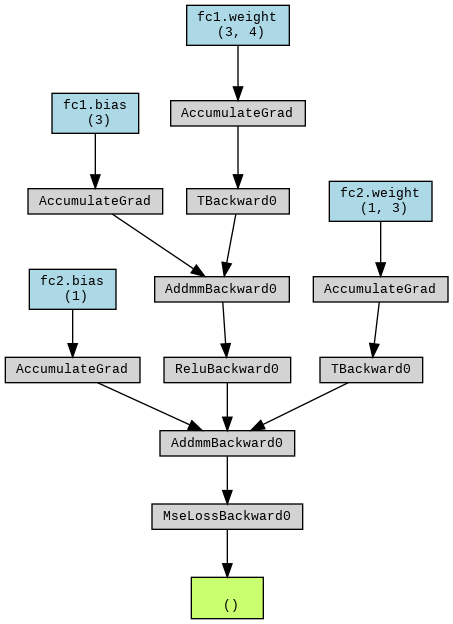

In [ ]:
from torchviz import make_dot
from IPython.display import Image

dot = make_dot(loss, params=dict(model.named_parameters()))
dot.render("computation_graph", format="png")
Image("computation_graph.png")



**The computation graph for autograd** shows **all operations and how gradients are computed**, including:

1. **Multiple inputs to the same operation**

   * For example, `AddmmBackward0` receives both the previous layer’s output and the layer’s bias → two arrows pointing to it.

2. **Parallel gradient paths**

   * Each parameter has its own `AccumulateGrad` node where its gradient will be stored.
   * Gradients flow back **simultaneously** through different branches.

3. **Non-linearities create branching**

   * ReLU doesn’t just pass forward — it also creates a `ReluBackward0` node, which is part of the gradient chain.

4. **Loss connects to multiple parameters**

   * The same loss depends on `fc1` and `fc2` parameters → the graph shows **branching backward paths**.

---




In [ ]:
print(f"Before backward(), params : {list(model.parameters())}")
loss.backward()
print(f"\nAfter backward(), params : {list(model.parameters())}")

Before backward(), params : [Parameter containing:
tensor([[ 0.0717, -0.3069,  0.3673, -0.1639],
        [-0.3930, -0.2620, -0.4400,  0.2956],
        [ 0.1346, -0.0923,  0.3324, -0.2831]], requires_grad=True), Parameter containing:
tensor([ 0.4736, -0.4135, -0.3320], requires_grad=True), Parameter containing:
tensor([[ 0.3155, -0.2440, -0.3907]], requires_grad=True), Parameter containing:
tensor([0.0756], requires_grad=True)]

After backward(), params : [Parameter containing:
tensor([[ 0.0717, -0.3069,  0.3673, -0.1639],
        [-0.3930, -0.2620, -0.4400,  0.2956],
        [ 0.1346, -0.0923,  0.3324, -0.2831]], requires_grad=True), Parameter containing:
tensor([ 0.4736, -0.4135, -0.3320], requires_grad=True), Parameter containing:
tensor([[ 0.3155, -0.2440, -0.3907]], requires_grad=True), Parameter containing:
tensor([0.0756], requires_grad=True)]


# No update in weights?

After you call `loss.backward()` in PyTorch, you’ve computed the gradients of your loss with respect to all the parameters that have `requires_grad=True`. The next steps usually involve **updating the model parameters** using these gradients and then optionally **clearing them** before the next iteration. Here's a clear step-by-step outline:

---

###  **Update parameters**

You usually do this with an optimizer, e.g., `torch.optim.SGD` or `Adam`.


In [ ]:
import torch.optim as optim

print(f"Before optimizer, params : {list(model.parameters())}")
optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer.step()  ## this updates weights
print(f"\nAfter backward(), params : {list(model.parameters())}")

Before optimizer, params : [Parameter containing:
tensor([[ 0.0717, -0.3069,  0.3673, -0.1639],
        [-0.3930, -0.2620, -0.4400,  0.2956],
        [ 0.1346, -0.0923,  0.3324, -0.2831]], requires_grad=True), Parameter containing:
tensor([ 0.4736, -0.4135, -0.3320], requires_grad=True), Parameter containing:
tensor([[ 0.3155, -0.2440, -0.3907]], requires_grad=True), Parameter containing:
tensor([0.0756], requires_grad=True)]

After backward(), params : [Parameter containing:
tensor([[ 0.0715, -0.3071,  0.3668, -0.1640],
        [-0.3930, -0.2620, -0.4400,  0.2956],
        [ 0.1344, -0.0922,  0.3337, -0.2824]], requires_grad=True), Parameter containing:
tensor([ 0.4726, -0.4135, -0.3314], requires_grad=True), Parameter containing:
tensor([[ 0.3135, -0.2440, -0.3907]], requires_grad=True), Parameter containing:
tensor([0.0720], requires_grad=True)]


---

### **Basic idea of optimizers**

After computing gradients:

$$
\frac{\partial \text{loss}}{\partial \theta_i} \quad \text{for each parameter } \theta_i
$$

The optimizer updates the parameters. For example, in **stochastic gradient descent (SGD)**:

$$
\theta_i \gets \theta_i - \eta \frac{\partial \text{loss}}{\partial \theta_i}
$$

Where:

* $\eta$ = learning rate
* $\theta_i$ = model parameter
* $\frac{\partial \text{loss}}{\partial \theta_i}$ = gradient



---

### 2. **Common optimizers**

* **SGD** (Stochastic Gradient Descent) – simplest, can use momentum.
* **Adam** – adapts learning rates per parameter, popular for deep learning.
* **RMSprop** – good for recurrent networks, adjusts learning rates based on recent gradients.
* **Adagrad** – adapts learning rates, favors infrequent features.

---

### 3. **Why we use optimizers**

* Gradients tell **direction**, but optimizers decide **how much and how exactly to move**.
* Some optimizers speed up convergence or stabilize training.

---


In [ ]:
optimizer.zero_grad()

 If you don’t call `optimizer.zero_grad()` (or `model.zero_grad()`), the next iteration’s gradients will be added to the previous ones instead of replacing them. This is usually **not what you want** during standard training.




# Datasets & Dataloaders

In deep learning, we rarely work with **one big tensor of all data** — that would be inefficient and often too large for memory.

Instead, training happens in **mini-batches** (chunks of data).
So we need a mechanism to:

* Split data into batches
* Shuffle it for randomness
* Load it efficiently (even from disk)

That’s exactly what **Dataset** and **DataLoader** handle.



In [ ]:
from torchvision import datasets, transforms

##  `Dataset` — defines how to access your data

A **Dataset** is like a wrapper around your actual data. It tells PyTorch:

* **How many samples** you have (`__len__`)
* **How to get one sample** (`__getitem__`)

You can use **built-in** datasets (like MNIST, CIFAR10), or make your **own custom one**.

---


In [ ]:
train_ds = datasets.MNIST(
    root='./data', train=True,      ## give the train data not test, make False to get test data
    transform=transforms.ToTensor(),
    download=True
)

# Here, train_ds knows how to give you one (image, label) pair

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.76MB/s]


In [ ]:
for image, target in train_ds:
    print(f"Image shape: {image.shape}, label: {target}")
    break

## MNIST has each image of 28*28 and is grayscale so only 1 channel

Image shape: torch.Size([1, 28, 28]), label: 5




###  Custom dataset

You can create your own:



In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



Now:


In [ ]:
X = torch.randn(100, 10)
y = torch.randint(0, 2, (100,))

torch.randn()

data = MyDataset(X, y)
print(len(data))       # total samples
print(data[0])         # first sample


100
(tensor([-1.2597,  2.5302, -1.6251,  1.9022,  0.1483, -0.7836, -0.7778,  1.1459,
         0.3462,  0.2734]), tensor(1))


## `DataLoader` — handles batching and shuffling

`DataLoader` wraps a Dataset and automatically:

* Splits it into **mini-batches**
* **Shuffles** data every epoch (if you want)
* Can **load in parallel** using multiple workers (faster I/O)

Example:




In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(data, batch_size=16, shuffle=True)


Then in training:





In [ ]:
for inputs, target in loader:
    print(inputs.shape, target.shape)
    break

## this is how you get data in a loop, with batching/shuffling

torch.Size([16, 10]) torch.Size([16])


# Head over to next notebook for further expansion